In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.mode.copy_on_write = True

# Load filtered file and file with segmentation results

In [2]:
# load filtered points
df_filtered_pts = pd.read_csv("download_imgs/selected_points.csv")
df_filtered_pts.groupby("city").size()

city
Abuja              185
Amsterdam         3538
San Francisco    25916
Santiago           645
Singapore         1985
dtype: int64

In [3]:
# The global streetscapes have the results of semantic segmentation
df_seg = pd.read_csv(
    "data/global-streetscapes/data/segmentation.csv"
)
df_seg

,Unnamed: 0,uuid,source,orig_id,Bird,Ground-Animal,Curb,Fence,Guard-Rail,Barrier,...,Caravan,Motorcycle,On-Rails,Other-Vehicle,Trailer,Truck,Wheeled-Slow,Car-Mount,Ego-Vehicle,Total
0,0,fab85b76-8fe7-433c-9109-dcd99a25a620,Mapillary,9.631169e+14,0,0,11012,63352,0,0,...,0,0,0,0,0,0,0,0,0,3049296
1,1,14da5502-276a-4b0e-ab1b-9969bef7cf3a,Mapillary,2.526096e+14,0,0,8244,0,0,0,...,0,0,0,0,0,0,0,0,816876,2310228
2,2,2fa06463-49f6-4d0c-8fdc-4ebf1754b996,Mapillary,9.966409e+14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3049192
3,3,9cf979a3-4e27-4935-b2cf-6dae1b883ecd,Mapillary,9.381521e+14,0,0,11544,128652,0,0,...,0,0,0,0,0,0,0,0,0,3124480
4,4,7c7c7ad0-6449-4472-b8dc-ea9d35f4ee5f,Mapillary,9.689141e+14,0,0,276,26040,24608,185396,...,0,0,0,0,0,0,0,0,20696,3039580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9236475,9236475,08b9ebe0-dff0-4024-bd00-5529b9ed3eae,Mapillary,2.879156e+14,0,0,0,967,1846,0,...,0,0,0,0,0,0,0,0,0,3145728
9236476,9236476,28934a90-2cb7-437f-a28c-996b37bc4009,Mapillary,5.696530e+14,0,0,572,37448,0,0,...,0,0,0,0,0,0,0,0,0,3145728
9236477,9236477,0d258fa2-7ad7-4edd-b32a-9cc44748bfda,Mapillary,2.964260e+15,0,0,5111,130,0,0,...,0,0,0,0,0,0,0,0,0,3145728
9236478,9236478,6ff777db-522c-42a8-bf0d-097691c4da8d,Mapillary,3.756884e+14,0,0,48439,361849,0,0,...,0,0,0,0,0,268,0,0,0,3145728


# Merge filtered points and segmentation values

In [4]:
df_filtered_pts = pd.merge(
    df_filtered_pts, df_seg, on=["orig_id", "source"], how="left"
)
df_filtered_pts

/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_11101/4073835905.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_filtered_pts = pd.merge(


,Unnamed: 0_x,uuid_x,source,orig_id,city,city_ascii,city_id,city_lat,city_lon,country,...,Caravan,Motorcycle,On-Rails,Other-Vehicle,Trailer,Truck,Wheeled-Slow,Car-Mount,Ego-Vehicle,Total
0,3,642298a7-563e-4650-b308-5e4371238b84,Mapillary,300520878202732,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3016736.0
1,4,32eeddbe-c4f0-4ac1-aff0-a0d19d258ae5,Mapillary,416737606538178,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3008448.0
2,24,ea7fe287-8fd1-4f53-90f9-f58e30d8b932,Mapillary,307579597410958,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3115016.0
3,50,bd7522fa-6f84-4790-b3e0-635a1c7b882e,Mapillary,162594799504192,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,9564.0,0.0,0.0,0.0,0.0,0.0,0.0,3095252.0
4,57,08e8a8a6-e79a-4e98-b156-87c3522a2335,Mapillary,869032384492850,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3067024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32264,129419,799a5ffc-cb9c-43d2-8588-501023619e67,KartaView,1332818717,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0
32265,129527,b3c76503-f7a4-4867-8432-6c42c691f5cc,KartaView,1332820389,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0
32266,129559,9e9b4458-e259-4421-ac43-a2fa85a2b7d7,KartaView,1332820525,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0
32267,129562,c6073659-558d-435e-a92d-f8b1be669877,KartaView,1332820537,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0


In [5]:
df_filtered_pts.groupby("city").size()

city
Abuja              185
Amsterdam         3538
San Francisco    25916
Santiago           645
Singapore         1985
dtype: int64

# Visual complexity calculation

In [6]:
# remove images where segmentation failed
print("Images with 0 value in total pixel count are a result of failed segmentation")
print(f"Num. images where segmentation failed: {df_filtered_pts[df_filtered_pts['Total'] == 0].shape[0]}")

df_filtered_pts = df_filtered_pts[df_filtered_pts["Total"] != 0]
df_filtered_pts.shape

Images with 0 value in total pixel count are a result of failed segmentation
Num. images where segmentation failed: 0


(32269, 92)

In [7]:
idx_class_1 = df_filtered_pts.columns.get_loc('Bird')
idx_class_1

26

In [8]:
# Loop through semantic classes (mapillary has 65 classes) and compute Visual Complexity
df_indicators = df_filtered_pts.iloc[:, idx_class_1:]
list_indicators = df_indicators.to_dict("records")

# Keep track of calculations
numpy_array_list = list()

# All_indicators is a dictionary containing the number of pixels per semantic class for each image
for all_indicators in list_indicators:
    temp = list()

    for s_class_key, s_class_val in all_indicators.items():
        if s_class_key == "Total":
            break  # only calculate ratio for the 65 classes
        else:
            # all_indicators['Total'] contains total number of pixels of an image
            prob = round(s_class_val / all_indicators["Total"], 4)
            temp.append(prob)

    numpy_array_list.append(np.array(temp))

# Add Visual Complexity and remove images with threshold less than <1.0> (probably pointing at road or wall)
df_filtered_pts["visual_complexity"] = [entropy(array) for array in numpy_array_list]

In [9]:
# Descriptive statistics of the visual complexity values
min_value = df_filtered_pts['visual_complexity'].min()
max_value = df_filtered_pts['visual_complexity'].max()
mean_value = df_filtered_pts['visual_complexity'].mean()
median_value = df_filtered_pts['visual_complexity'].median()
quantiles = df_filtered_pts['visual_complexity'].quantile([0.25, 0.5, 0.75])

print("Min:", min_value)
print("Max:", max_value)
print("Mean:", mean_value)
print("Median:", median_value)
print("Quantiles:")
print(quantiles)

Min: 0.0
Max: 2.4715096391785663
Mean: 1.6956144852147454
Median: 1.707315836026471
Quantiles:
0.25    1.588028
0.50    1.707316
0.75    1.820854
Name: visual_complexity, dtype: float64


In [10]:
# filter our images with threshold less than VC_THRESHOLD (probably pointing at road or wall)
VC_THRESHOLD = 1.5

print(f"Num of images to filter out: {df_filtered_pts[df_filtered_pts['visual_complexity'] < VC_THRESHOLD].shape[0]}")
df_filtered_pts = df_filtered_pts[df_filtered_pts['visual_complexity'] >= VC_THRESHOLD]
df_filtered_pts

Num of images to filter out: 4357


,Unnamed: 0_x,uuid_x,source,orig_id,city,city_ascii,city_id,city_lat,city_lon,country,...,Motorcycle,On-Rails,Other-Vehicle,Trailer,Truck,Wheeled-Slow,Car-Mount,Ego-Vehicle,Total,visual_complexity
0,3,642298a7-563e-4650-b308-5e4371238b84,Mapillary,300520878202732,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3016736.0,1.530712
1,4,32eeddbe-c4f0-4ac1-aff0-a0d19d258ae5,Mapillary,416737606538178,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3008448.0,1.677172
4,57,08e8a8a6-e79a-4e98-b156-87c3522a2335,Mapillary,869032384492850,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3067024.0,1.653967
5,63,e92baa64-2185-4e7e-a4d7-c28b4cf1c4c1,Mapillary,294370446217494,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015660.0,1.744651
6,66,138f11c5-11bd-4afe-abd6-8bad7a6f5026,Mapillary,111486781500213,Amsterdam,Amsterdam,1528355309,52.3667,4.8833,Netherlands,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3077104.0,1.736637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32259,129392,582e0679-f3c9-4b6e-81f9-95c0b758f112,KartaView,1332818017,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0,1.877243
32262,129395,1589e4b2-4d73-4413-95a4-63c1fdd51f8e,KartaView,1332818029,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,6418.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0,1.687396
32263,129418,06e1a7e7-aa0d-4ed1-b557-547f77337c23,KartaView,1332818125,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,747.0,0.0,0.0,0.0,5992704.0,2.024821
32264,129419,799a5ffc-cb9c-43d2-8588-501023619e67,KartaView,1332818717,San Francisco,San Francisco,1840021543,37.7562,-122.4430,United States,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5992704.0,1.906297


# Ratio calculation for each city

In [11]:
# Singapore, Amsterdam, San Francisco, Abuja, Santiago
city_id = [1702341327, 1528355309, 1840021543, 1566342270, 1152554349]

city_names = {
    1702341327: "Singapore",
    1528355309: "Amsterdam",
    1840021543: "San Francisco",
    1566342270: "Abuja",
    1152554349: "Santiago",
}
dict_df_filtered_pts = {}  # dict to hold a dataframe per city. city_id : {dataframe}

In [12]:
# calculate the ratio of each element in each city
for id in city_id:
    # filter each city
    dict_df_filtered_pts[id] = df_filtered_pts[df_filtered_pts["city_id"] == id]

    # calculate ratio of each element
    dict_df_filtered_pts[id]["Road_ratio"] = (
        dict_df_filtered_pts[id]["Road"] / dict_df_filtered_pts[id]["Total"]
    )
    dict_df_filtered_pts[id]["Vegetation_ratio"] = (
        dict_df_filtered_pts[id]["Vegetation"] / dict_df_filtered_pts[id]["Total"]
    )
    dict_df_filtered_pts[id]["Car_ratio"] = (
        dict_df_filtered_pts[id]["Car"] / dict_df_filtered_pts[id]["Total"]
    )
    dict_df_filtered_pts[id]["Building_ratio"] = (
        dict_df_filtered_pts[id]["Building"] / dict_df_filtered_pts[id]["Total"]
    )
    dict_df_filtered_pts[id]["Sky_ratio"] = (
        dict_df_filtered_pts[id]["Sky"] / dict_df_filtered_pts[id]["Total"]
    )

In [13]:
# debugging
dict_df_filtered_pts[1702341327]

,Unnamed: 0_x,uuid_x,source,orig_id,city,city_ascii,city_id,city_lat,city_lon,country,...,Wheeled-Slow,Car-Mount,Ego-Vehicle,Total,visual_complexity,Road_ratio,Vegetation_ratio,Car_ratio,Building_ratio,Sky_ratio
3931,37185,1c80da17-697e-485b-b513-7925b07d8d92,Mapillary,865783177614020,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,2044260.0,1.876654,0.118965,0.060797,0.016989,0.136482,0.278301
3934,37221,e256fdf0-c55f-48fc-b55c-13b310243e3b,Mapillary,826518501302716,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,107425.0,2005395.0,1.993278,0.079747,0.248659,0.005505,0.037918,0.323582
3936,37229,aefe21c3-f761-4a7f-b332-cccef585f556,Mapillary,300351374915837,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,3101724.0,1.837808,0.098427,0.391328,0.025908,0.085638,0.248062
3937,37237,2b21fe5c-7dff-47ee-a9d7-de29e60c6db0,Mapillary,240760857851346,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,1991090.0,1.568897,0.111652,0.270545,0.000000,0.009440,0.368394
3940,37273,0360bbde-e995-41bd-9bf0-cd23b7bf5543,Mapillary,150295603732550,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,137690.0,1995155.0,2.077059,0.082021,0.297318,0.000524,0.087229,0.241753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,59752,d11f1560-f10d-436f-a949-9fd18b82a84f,KartaView,1711800169,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,7728225.0,1.764074,0.231875,0.420835,0.003050,0.087613,0.055384
5912,59753,3ef324a5-f163-4ee0-b9d3-570d8be91f92,KartaView,1711798889,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,7423182.0,2.144910,0.070260,0.213247,0.000695,0.170706,0.087787
5913,59754,c8d89d9a-91a8-4916-afb6-cb419e086370,KartaView,1711800185,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,7730202.0,1.705710,0.268488,0.418449,0.006605,0.069972,0.029198
5914,59756,c4109fc0-466c-495e-bf41-d45ad202c46b,KartaView,1711800217,Singapore,Singapore,1702341327,1.3,103.8,Singapore,...,0.0,0.0,0.0,7752108.0,1.681528,0.242309,0.461817,0.002589,0.045664,0.063464


# Clustering

## SCALING THE FEATURES

Elbow plot for Singapore


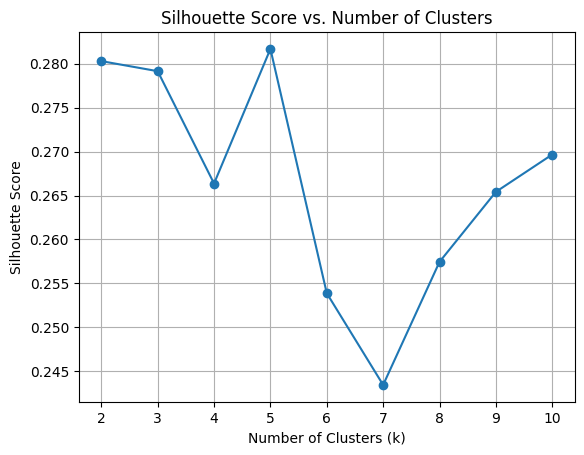

Elbow plot for Amsterdam


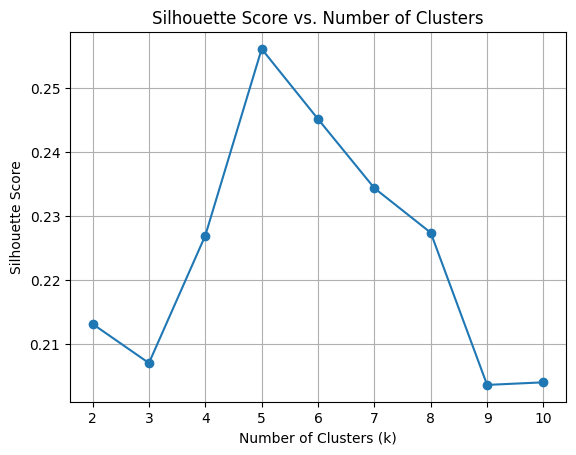

Elbow plot for San Francisco


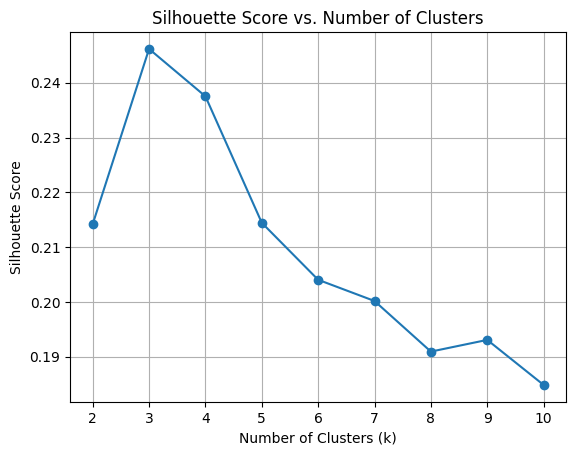

Elbow plot for Abuja


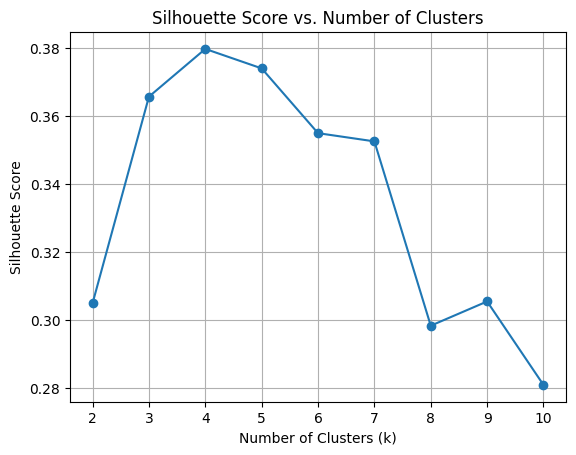

Elbow plot for Santiago


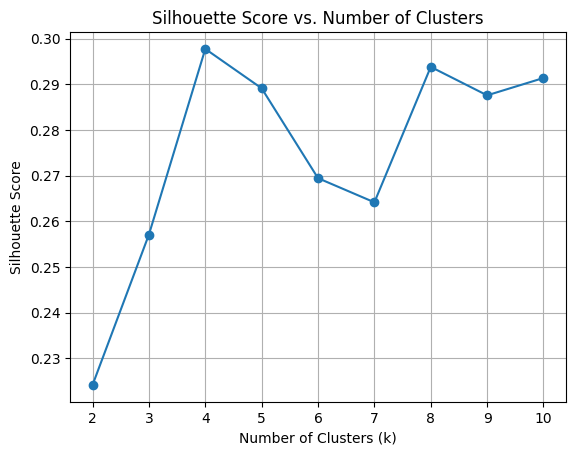

{1702341327: 5, 1528355309: 5, 1840021543: 3, 1566342270: 4, 1152554349: 4}


In [15]:
# Define a range of k values to try
k_values = range(2, 11)
silhouette_scores = {}
chosen_k = {}

for id in city_id:
    # filter each city and prepare data
    X = dict_df_filtered_pts[id][
        ["Road_ratio", "Vegetation_ratio", "Car_ratio", "Building_ratio", "Sky_ratio"]
    ]
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # keep track of the silhouette scores
    silhouette_scores[id] = []

    # Iterate over each value of k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores[id].append(silhouette_avg)

    # find the k with highest score
    idx_chosen_k = silhouette_scores[id].index(max(silhouette_scores[id]))
    chosen_k[id] = k_values[idx_chosen_k]

    # Plot silhouette scores
    print(f"Elbow plot for {city_names[id]}")
    plt.plot(k_values, silhouette_scores[id], marker="o")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

print(chosen_k)

## Apply clustering with chosen k value

In [16]:
for id in city_id:
    # filter each city and prepare data
    X = dict_df_filtered_pts[id][
        ["Road_ratio", "Vegetation_ratio", "Car_ratio", "Building_ratio", "Sky_ratio"]
    ]
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # perform clustering
    k = chosen_k[id]
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(X_scaled)

    dict_df_filtered_pts[id]["cluster_label"] = kmeans.labels_

In [17]:
# debugging
for id in city_id:
    print(dict_df_filtered_pts[id].shape)

(1289, 99)
(2706, 99)
(22680, 99)
(108, 99)
(520, 99)


# Save to csv

In [18]:
# concatenate the dictionary and save it to a csv file
df_concatenated = pd.concat(dict_df_filtered_pts.values(), ignore_index=True)
df_concatenated.to_csv("download_imgs/clustered_points.csv")
df_concatenated

,Unnamed: 0_x,uuid_x,source,orig_id,city,city_ascii,city_id,city_lat,city_lon,country,...,Car-Mount,Ego-Vehicle,Total,visual_complexity,Road_ratio,Vegetation_ratio,Car_ratio,Building_ratio,Sky_ratio,cluster_label
0,37185,1c80da17-697e-485b-b513-7925b07d8d92,Mapillary,865783177614020,Singapore,Singapore,1702341327,1.30,103.8000,Singapore,...,0.0,0.0,2044260.0,1.876654,0.118965,0.060797,0.016989,0.136482,0.278301,2
1,37221,e256fdf0-c55f-48fc-b55c-13b310243e3b,Mapillary,826518501302716,Singapore,Singapore,1702341327,1.30,103.8000,Singapore,...,0.0,107425.0,2005395.0,1.993278,0.079747,0.248659,0.005505,0.037918,0.323582,2
2,37229,aefe21c3-f761-4a7f-b332-cccef585f556,Mapillary,300351374915837,Singapore,Singapore,1702341327,1.30,103.8000,Singapore,...,0.0,0.0,3101724.0,1.837808,0.098427,0.391328,0.025908,0.085638,0.248062,3
3,37237,2b21fe5c-7dff-47ee-a9d7-de29e60c6db0,Mapillary,240760857851346,Singapore,Singapore,1702341327,1.30,103.8000,Singapore,...,0.0,0.0,1991090.0,1.568897,0.111652,0.270545,0.000000,0.009440,0.368394,2
4,37273,0360bbde-e995-41bd-9bf0-cd23b7bf5543,Mapillary,150295603732550,Singapore,Singapore,1702341327,1.30,103.8000,Singapore,...,0.0,137690.0,1995155.0,2.077059,0.082021,0.297318,0.000524,0.087229,0.241753,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,37144,dc6eee81-9513-4edb-813b-05b83b5127be,Mapillary,2905139663075259,Santiago,Santiago,1152554349,-33.45,-70.6667,Chile,...,20850.0,0.0,2013700.0,1.733101,0.084856,0.109167,0.000000,0.045091,0.452324,1
27299,37148,58f7ab3a-95f2-4e63-aa52-9111798c12c9,Mapillary,1188476305232671,Santiago,Santiago,1152554349,-33.45,-70.6667,Chile,...,46230.0,189570.0,2244579.0,2.128048,0.291580,0.122134,0.081733,0.089744,0.175526,0
27300,37153,6c330b03-2960-4456-9683-33c2414a2f40,Mapillary,317767673096061,Santiago,Santiago,1152554349,-33.45,-70.6667,Chile,...,0.0,31035.0,1968085.0,2.309947,0.107196,0.149529,0.013254,0.154942,0.218123,2
27301,37156,1f3e335f-9029-49f2-8e4a-6b5f522f5bbf,Mapillary,486233076032026,Santiago,Santiago,1152554349,-33.45,-70.6667,Chile,...,0.0,128150.0,2001520.0,1.505885,0.001237,0.142749,0.000452,0.384116,0.043040,3
